# Hate Speech on Hit Songs using BERT model



In [1]:
#importing some required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 

In [2]:
!wget https://raw.githubusercontent.com/idontflow/OLID/master/olid-training-v1.0.tsv 

--2021-01-05 10:43:38--  https://raw.githubusercontent.com/idontflow/OLID/master/olid-training-v1.0.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1961915 (1.9M) [text/plain]
Saving to: ‘olid-training-v1.0.tsv.2’

olid-training-v1.0. 100%[===================>]   1.87M  --.-KB/s    in 0.1s    

2021-01-05 10:43:38 (17.0 MB/s) - ‘olid-training-v1.0.tsv.2’ saved [1961915/1961915]



In [3]:
import pandas as pd
olid=pd.read_csv('olid-training-v1.0.tsv',sep='\t') 

In [4]:
!wget https://raw.githubusercontent.com/idontflow/OLID/master/own/cleaned_train_data_v1.csv

--2021-01-05 10:43:38--  https://raw.githubusercontent.com/idontflow/OLID/master/own/cleaned_train_data_v1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2888647 (2.8M) [text/plain]
Saving to: ‘cleaned_train_data_v1.csv.2’

cleaned_train_data_ 100%[===================>]   2.75M  --.-KB/s    in 0.08s   

2021-01-05 10:43:39 (34.6 MB/s) - ‘cleaned_train_data_v1.csv.2’ saved [2888647/2888647]



In [5]:
olid_clean=pd.read_csv('cleaned_train_data_v1.csv') 

In [6]:
olid['tweet']=olid_clean['cleaned_tweet'].apply(str) 

In [7]:
olid.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,ask native americans take,OFF,UNT,NaN
1,90194,go home drunk maga trump 2020,OFF,TIN,IND
2,16820,amazon investigating chinese employees selling...,NOT,NaN,NaN
3,62688,someone vetaken piece shit volcano,OFF,UNT,NaN
4,43605,obama wanted liberals illegals move red states,NOT,NaN,NaN


In [8]:
#taking only the required columns after filtering
olid.rename(columns = {'tweet':'text'}, inplace = True) 
olid.rename(columns = {'subtask_a':'label'}, inplace = True)
train=olid[['id','text','label']]
print(train.head()) 

      id                                               text label
0  86426                          ask native americans take   OFF
1  90194                      go home drunk maga trump 2020   OFF
2  16820  amazon investigating chinese employees selling...   NOT
3  62688                 someone vetaken piece shit volcano   OFF
4  43605     obama wanted liberals illegals move red states   NOT


In [9]:
mapping = {'OFF': 1, 'NOT': 0}
train=train.replace({'label': mapping})
train.head() 

,id,text,label
0,86426,ask native americans take,1
1,90194,go home drunk maga trump 2020,1
2,16820,amazon investigating chinese employees selling...,0
3,62688,someone vetaken piece shit volcano,1
4,43605,obama wanted liberals illegals move red states,0


In [10]:
#splitting train dataset for training and validation
from sklearn.model_selection import train_test_split
X = train.text.values
y = train.label.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42) 

In [11]:
#gpu setup
import torch
import torch.nn as nn

device = torch.device("cuda")

In [12]:
#installing transformers
!pip install transformers==2.8.0
from transformers import BertModel

In [13]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

In [14]:
def text_preprocessing(s):
    s = re.sub(r'(@.*?)[\s]', ' ', s) #removing @mentions
    s = re.sub(r"\n", ".", s) #replacing \n with .
    s = re.sub(r'\s+', ' ', s).strip() #removing trailing whitespace
    s = re.sub(r'\[(.*?)\]',' ', s)
    return s
    
def bert_preprocessing(data):
    input_ids = []
    attention_masks = []
    for texts in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(texts),
            add_special_tokens=True,      
            max_length=400,                               
            pad_to_max_length=True,  
            return_attention_mask=True 
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    return input_ids, attention_masks

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
train_inputs, train_masks = bert_preprocessing(X_train)
val_inputs, val_masks = bert_preprocessing(X_val)
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=8)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=8)

According to BERT Paper section 3:
The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks.

In [16]:
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        input, hidden, out = 768, 50, 2
        self.bert = BertModel.from_pretrained('bert-base-multilingual-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(input, hidden),
            nn.GELU(),
            nn.Linear(hidden, out)
        )
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits

In [17]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    bert_classifier = BertClassifier(freeze_bert=False)
    bert_classifier.to(device)
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,   
                      eps=1e-8   
                      )
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [18]:
import time
loss_fn = nn.CrossEntropyLoss()

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            if (step % 80 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
        avg_train_loss = total_loss / len(train_dataloader)
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")


def evaluate(model, val_dataloader):
    model.eval()
    val_accuracy = []
    val_loss = []
    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

In [19]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True) 

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


   1    |   0.539518   |  0.518162  |   76.96   |  573.19  
----------------------------------------------------------------------


 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   0.459586   |  0.532836  |   77.56   |  573.13  
----------------------------------------------------------------------




In [20]:
def bert_predict(model, test_dataloader):
    model.eval()
    all_logits = []
    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    all_logits = torch.cat(all_logits, dim=0)
    m = nn.Softmax(dim=0)
    probs=m(all_logits).cpu().numpy()
    return probs

In [21]:
probs = bert_predict(bert_classifier, val_dataloader)
from sklearn.metrics import accuracy_score

ypred = []
for i in probs:
  ypred.append(i.argmax())

accuracy_score(y_val, ypred)

0.7719033232628398

In [22]:
from sklearn.metrics import confusion_matrix 

In [23]:
actual = y_val 
predicted = ypred
results = confusion_matrix(actual, predicted)

In [24]:
from sklearn.metrics import classification_report
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(actual, predicted)) 
print ('Report : ')
print (classification_report(actual, predicted) )

Confusion Matrix :
[[678 174]
 [128 344]]
Accuracy Score : 0.7719033232628398
Report : 
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       852
           1       0.66      0.73      0.69       472

    accuracy                           0.77      1324
   macro avg       0.75      0.76      0.76      1324
weighted avg       0.78      0.77      0.77      1324



In [25]:
#importing the test dataset
df2 = pd.read_csv('https://query.data.world/s/5zp7kqkhp6aycvezneyvw4s5vncwyp')
df2['WeekID'] =pd.to_datetime(df2.WeekID)
df2['Year'] = pd.DatetimeIndex(df2['WeekID']).year
df2.rename(columns = {'Year':'id'}, inplace = True) 
df2.rename(columns = {'Lyrics':'text'}, inplace = True)
test=df2[['id','text']]
print(test.head())

     id                                               text
0  1958  For your love, oh, I would do anything\nI woul...
1  1958  Do you want to dance and hold my hand?\nTell m...
2  1958  Well...\n\nYou're gonna miss me\nEarly in the ...
3  1958  VERSE 1\nThe night was black, rain falling dow...
4  1958  You need hands\nTo hold someone you care for\n...


In [26]:
!pip install langdetect

In [27]:
from langdetect import detect 
def text_language(text):
  text=text.split(" ")
  text=text[20:40]
  try:
    val = detect(" ".join(text))
  except:
    val = "error"
  return val

In [28]:
test['language']=test['text'].apply(text_language)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
yrs=[2014,2015,2016,2017,2018,2019]
all_preds=[]
preds_all=[]
df=pd.DataFrame()
for yr in yrs:
  test1=test.loc[test['id'] == yr]
  test1=test1.loc[test1['language'] == 'en']
  df=df.append(test1)
  test_inputs, test_masks = bert_preprocessing(test1.text)
  test_dataset = TensorDataset(test_inputs, test_masks)
  test_sampler = SequentialSampler(test_dataset)
  test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)
  probs = bert_predict(bert_classifier, test_dataloader)
  ypred = []
  for i in probs:
    ypred.append(i.argmax())
  ypred = pd.Index(ypred)
  print(yr)
  preds_all.append(ypred.values)
  all_preds.append([yr, ypred.value_counts()])

2014
2015
2016
2017
2018
2019


In [30]:
preds_all=pd.Series(preds_all)  

In [31]:
df=pd.DataFrame(df)

In [32]:
preds_all = preds_all.apply(pd.Series).stack().reset_index(drop = True) 

In [33]:
df=df.assign(Prediction=preds_all.values)

In [34]:
df.head()

,id,text,language,Prediction
23722,2014,"[Intro: Sample]\n""Flight controllers here look...",en,1.0
23723,2014,[Verse 1]\nI see you and me riding like Bonnie...,en,1.0
23724,2014,[Verse 1: BeyoncÃ©]\nI've been watching for th...,en,0.0
23725,2014,"Share my life, take me for what I am\n'Cause I...",en,0.0
23726,2014,"[Chorus]\nI got my shades on, top back\nRollin...",en,1.0


In [35]:
Offensive=df.loc[df['Prediction'] == 1]
notOffensive=df.loc[df['Prediction'] == 0]

In [36]:
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
from nltk.corpus import stopwords 

words = '' 
stopwords = set(stopwords.words('english'))

for val in Offensive.text: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


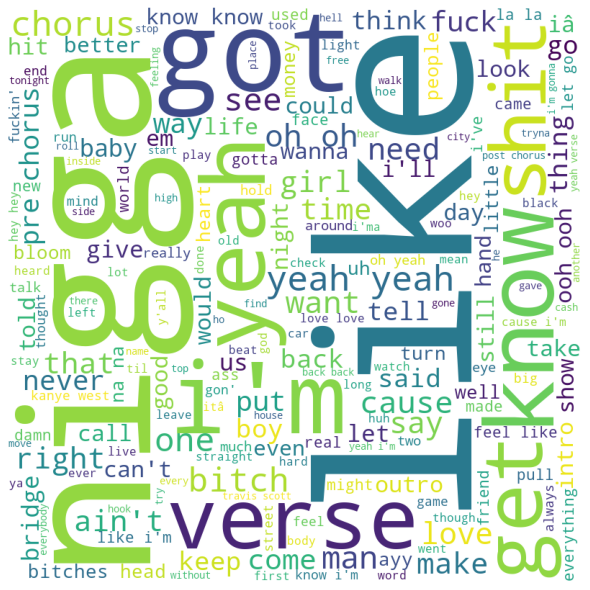

In [37]:
plt.figure(figsize = (8,8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [38]:
temp = []

for i in range(len(all_preds)):
  temp.append([all_preds[i][0], all_preds[i][1][0], all_preds[i][1][1]])

temp = pd.DataFrame(temp)
temp.columns = ['year', 'sent0', 'sent1']
temp

,year,sent0,sent1
0,2014,135,194
1,2015,148,227
2,2016,135,258
3,2017,120,290
4,2018,130,413
5,2019,60,170


In [39]:
for i in range(6):
  sm=temp['sent0']+temp['sent1']
  temp['sent0']=(temp['sent0']/sm)*100
  temp['sent1']=(temp['sent1']/sm)*100

In [40]:
import seaborn as sns

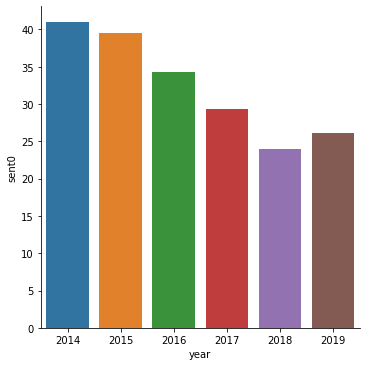

In [41]:
sns.catplot(x="year",y="sent0",data=temp,kind='bar')

In [42]:
!wget https://raw.githubusercontent.com/JAugusto97/ToLD-Br/main/ToLD-BR.csv

--2021-01-05 11:07:29--  https://raw.githubusercontent.com/JAugusto97/ToLD-Br/main/ToLD-BR.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2430416 (2.3M) [text/plain]
Saving to: ‘ToLD-BR.csv’

ToLD-BR.csv         100%[===================>]   2.32M  --.-KB/s    in 0.1s    

2021-01-05 11:07:30 (18.7 MB/s) - ‘ToLD-BR.csv’ saved [2430416/2430416]



In [43]:
import pandas as pd
told_br=pd.read_csv('ToLD-BR.csv') 

In [44]:
told_br

,text,homophobia,obscene,insult,racism,misogyny,xenophobia
0,Meu nivel de amizade com isis é ela ter meu in...,0.0,0.0,2.0,0.0,0.0,0.0
1,"rt @user @user o cara adultera dados, que fora...",0.0,0.0,1.0,0.0,0.0,0.0
2,@user @user @user o cara só é simplesmente o m...,0.0,2.0,1.0,0.0,0.0,0.0
3,eu to chorando vei vsf e eu nem staneio izone ...,0.0,1.0,0.0,0.0,0.0,0.0
4,Eleitor do Bolsonaro é tão ignorante q não per...,0.0,1.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
20995,@user faz favor vai carai,0.0,0.0,0.0,0.0,0.0,0.0
20996,só queria conhecer alguém que não conhece o he...,1.0,0.0,0.0,0.0,0.0,0.0
20997,"vcs militam na hora errada em cima de memes, p...",0.0,0.0,0.0,0.0,0.0,0.0
20998,@user porra any eu tava c dor de cabeca e fui ...,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
told_br['None']=told_br.apply(lambda row: row.homophobia + row.obscene+ row.insult+ row.racism+ row.misogyny+ row.xenophobia, axis=1)

In [46]:
told_br.loc[told_br['None'] > 0, 'None'] = 1

In [47]:
told_br.rename(columns = {'None':'label'}, inplace = True)
told_br=told_br[['text','label']]
print(told_br.head()) 

                                                text  label
0  Meu nivel de amizade com isis é ela ter meu in...    1.0
1  rt @user @user o cara adultera dados, que fora...    1.0
2  @user @user @user o cara só é simplesmente o m...    1.0
3  eu to chorando vei vsf e eu nem staneio izone ...    1.0
4  Eleitor do Bolsonaro é tão ignorante q não per...    1.0


In [48]:
told_br_inputs, told_br_masks = bert_preprocessing(told_br.text)
told_br_dataset = TensorDataset(told_br_inputs, told_br_masks)
told_br_sampler = SequentialSampler(told_br_dataset)
told_br_dataloader = DataLoader(told_br_dataset, sampler=told_br_sampler, batch_size=32)
probs_told_br = bert_predict(bert_classifier, told_br_dataloader)
told_br_pred=[]
for i in probs_told_br:
    told_br_pred.append(i.argmax())
told_br_pred = pd.Index(told_br_pred)

In [51]:
actual = told_br['label']
predicted = told_br_pred
results = confusion_matrix(actual, predicted)

In [52]:
from sklearn.metrics import classification_report
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(actual, predicted)) 
print ('Report : ')
print (classification_report(actual, predicted) )

Confusion Matrix :
[[7245 4500]
 [4682 4573]]
Accuracy Score : 0.5627619047619048
Report : 
              precision    recall  f1-score   support

         0.0       0.61      0.62      0.61     11745
         1.0       0.50      0.49      0.50      9255

    accuracy                           0.56     21000
   macro avg       0.56      0.56      0.56     21000
weighted avg       0.56      0.56      0.56     21000



In [64]:
test

,id,text,language
0,1958,"For your love, oh, I would do anything\nI woul...",en
1,1958,Do you want to dance and hold my hand?\nTell m...,pt
2,1958,Well...\n\nYou're gonna miss me\nEarly in the ...,en
3,1958,"VERSE 1\nThe night was black, rain falling dow...",en
4,1958,You need hands\nTo hold someone you care for\n...,en
...,...,...,...
26133,2019,"[Intro: FXXXXY]\nBlood, blood, blood\nXanax dr...",en
26134,2019,[Intro]\nRight now\nI just need you to get rea...,en
26135,2019,"[Verse 1: Bryce Vine]\nOh shit, you live in th...",en
26136,2019,[Verse 1]\nStep out into the dawn\nYou pray 't...,en


In [66]:
preds_pt_all=[]
df_pt=pd.DataFrame()
test1=test.loc[test['language'] == 'pt']
df_pt=df.append(test1)
test_pt_inputs, test_pt_masks = bert_preprocessing(test1.text)
test_pt_dataset = TensorDataset(test_pt_inputs, test_pt_masks)
test_pt_sampler = SequentialSampler(test_pt_dataset)
test_pt_dataloader = DataLoader(test_pt_dataset, sampler=test_pt_sampler, batch_size=2)
probs_pt = bert_predict(bert_classifier, test_pt_dataloader)
y_pt_pred = []
for i in probs_pt:
  y_pt_pred.append(i.argmax())
y_pt_pred = pd.Index(y_pt_pred)

In [77]:
y_pt_pred

Int64Index([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
            1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
           dtype='int64')